# Ibovespa forecasting using neural networks

## Machine Learning Engineer Nanodegree - Capstone Proposal

### Import python packages

In [69]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch.nn import L1Loss
from torch.optim import Adam

from ibov.utils import load_config
from ibov.model import train, torch_data, model_fc1h, model_fc2h, model_lstm, Model
from ibov.feature import create_lags, consolidate_features, create_delta_sign, label_train_test, Normalize
from ibov.request import get_history
from ibov.metrics import calculate_metrics, model_prediction, benchmark_model, graphical_evaluation

### Loading Configs

In [2]:
# Load config dict
config = load_config()

In [3]:
# Feature Engineering Configs
window = config.get("feature").get("window")
variables = config.get("feature").get("variables")
test_split = config.get("feature").get("split").get("test")
valid_split = config.get("feature").get("split").get("valid")

# Data Configs
data_dir = config.get("data").get("dir")
ibov_ticker = config.get("ibov").get("ticker")
filename = config.get("data").get("file")
data_size = config.get("data").get("size")
ascending = config.get("data").get("ascending") == 'True'

# Model configurations
dropout = config.get("model").get("dropout")
hidden_layer = config.get("model").get("hidden_layer")
lr = config.get("model").get("lr")
seed = config.get("model").get("seed")
epochs = config.get("model").get("epochs")

### Data Collection

#### Capture new data

In [62]:
# Target collection
ibovespa = get_history(ticker=ibov_ticker, data_size=data_size, ascending=ascending)

# Calendar Variables
calendar_variables = pd.get_dummies(pd.DatetimeIndex(ibovespa['date']).weekday, prefix="weekday")
ibovespa = pd.concat([ibovespa, calendar_variables], axis = 1)
ibovespa[["weekday"]] = pd.DatetimeIndex(ibovespa['date']).weekday

# Stock Prices
for stock in config["ibov"]["stocks"]:    
    df = get_history(ticker=stock, data_size=data_size, ascending=ascending)
    df.rename(columns={"close": stock[:-3]},inplace=True)
    ibovespa = ibovespa.merge(df, how="inner", on="date")
    
# Label datapoint as train or test dataset
ibovespa = label_train_test(ibovespa, split=test_split, split_valid=valid_split, ascending=ascending)

# Save data on disk
ibovespa.to_csv(os.path.join(data_dir, filename), index=False)

#### Read Existing data

In [ ]:
# Read from disk
ibovespa = pd.read_csv(os.path.join(data_dir, filename))

### Data Exploration

It is important to evaluate data and get insights only form the train dataset. Otherwise, we will have a data leakage even before any model training.

In [63]:
explore_data = ibovespa[ibovespa["group"]=="train"]

numeric_columns = ['close', 'ITUB4', 'BBDC4', 'VALE3', 'PETR4', 'PETR3', 'ABEV3', 'BBAS3', 'B3SA3', 'ITSA4']
stocks_diff = explore_data[numeric_columns].pct_change().reset_index(drop=True)
stocks_diff.columns = ["diff_" + column for column in stocks_diff.columns]

complete_explore_data = pd.concat([explore_data, stocks_diff], axis=1).iloc[1:].reset_index(drop=True)
complete_explore_data.head()

,date,close,ITUB4,BBDC4,VALE3,PETR4,PETR3,ABEV3,BBAS3,B3SA3,...,diff_close,diff_ITUB4,diff_BBDC4,diff_VALE3,diff_PETR4,diff_PETR3,diff_ABEV3,diff_BBAS3,diff_B3SA3,diff_ITSA4
0,2019-08-07,102782.0,36.799999,34.889999,46.480000,25.600000,28.200001,20.629999,48.450001,43.439999,...,0.006049,0.036912,0.021071,-0.003003,-0.010819,-0.009484,0.007324,-0.001031,0.014953,0.026066
1,2019-08-08,104115.0,37.000000,35.060001,47.180000,26.350000,28.870001,20.170000,48.799999,45.330002,...,0.012969,0.005435,0.004873,0.015060,0.029297,0.023759,-0.022298,0.007224,0.043508,0.010008
2,2019-08-09,103996.0,36.720001,34.480000,45.490002,26.280001,28.620001,20.070000,48.650002,45.500000,...,-0.001143,-0.007568,-0.016543,-0.035820,-0.002657,-0.008660,-0.004958,-0.003074,0.003750,-0.004573
3,2019-08-12,101915.0,35.200001,33.759998,45.160000,25.650000,27.850000,19.480000,47.000000,44.240002,...,-0.020010,-0.041394,-0.020882,-0.007254,-0.023973,-0.026904,-0.029397,-0.033916,-0.027692,-0.035222
4,2019-08-13,103299.0,35.889999,34.099998,46.500000,25.790001,27.959999,19.379999,47.549999,45.860001,...,0.013580,0.019602,0.010071,0.029672,0.005458,0.003950,-0.005133,0.011702,0.036618,0.025397


#### Weekday Boxplots

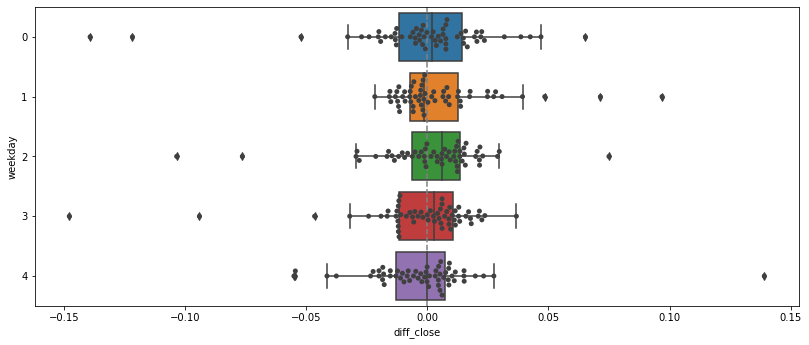

In [84]:
f, ax = plt.subplots(figsize=(13.7, 5.5))
sns.boxplot(y="weekday", x="diff_close", data=complete_explore_data, orient="h", ax=ax)
sns.swarmplot(x="diff_close", y="weekday", orient="h", data=complete_explore_data, color=".25", ax=ax)
plt.axvline(0, 0,1, ls="--", color="gray")

#### Weekday Distplots

### Feature Engineering

In [ ]:
scaler = Normalize()
scaler.fit(ibovespa[ibovespa["group"]=="train"][["close"]])
ibovespa[["close"]] = scaler.transform(ibovespa[["close"]])

In [ ]:
# Create lag variables
ibov_lags_df = create_lags(ibovespa, window=window, var="close", index="date")

In [ ]:
# Create sign variables
ibov_delta_sign_df = create_delta_sign(ibov_lags_df, var="lags", index="date", window=window)

In [ ]:
# Consolidate raw data with features
master_table = consolidate_features(ibovespa, "date", ibov_lags_df, ibov_delta_sign_df)

In [ ]:
# Load data to torch standard
train_loader, train_x_tensor, train_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="train")

valid_loader, valid_x_tensor, valid_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="valid")

test_loader, test_x_tensor, test_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="test")

### Training step

In [ ]:
from torch import nn
import torch

In [ ]:
class Model(nn.Module):

    def __init__(self, input_layer, hidden_layer=50, dropout=0.25):

        super(Model, self).__init__()
        self.hidden_layer = hidden_layer
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_layer, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer+hidden_layer, 1)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer),
                            torch.zeros(1,1,self.hidden_layer))
        
        self.lstm = nn.LSTM(input_layer, hidden_layer)
        
    def forward(self, input):

        x = input[:,0,:]
        z = input[:,1,:]
        x = self.fc1(x)
        x = self.dropout(x)

        lstm_out, self.hidden_cell = self.lstm(z.view(len(z),1 , -1), self.hidden_cell)
        ds = torch.cat((x,lstm_out[:,0,:]),1)
        output = self.fc2(ds)

        return output

In [ ]:
# Model definition
model = Model(input_layer=window, hidden_layer=hidden_layer, dropout=dropout)
criterion = L1Loss()
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
# Model training
train(model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, seed=seed)

### Evaluation

In [ ]:
# Model performance on Training dataset
train_true, train_pred = model_prediction(model, train_x_tensor, train_y_tensor)
calculate_metrics(train_true, train_pred)

In [ ]:
# Model performance on Validation dataset
valid_true, valid_pred = model_prediction(model, valid_x_tensor, valid_y_tensor)
calculate_metrics(valid_true, valid_pred) 

In [ ]:
# Model performance on Test dataset
test_true, test_pred = model_prediction(model, test_x_tensor, test_y_tensor)
calculate_metrics(test_true, test_pred)

### Benchmark Model

In [ ]:
# Set and Evaludate Benchmark Model
bmk_true, bmk_pred = benchmark_model(test_y_tensor, valid_y_tensor)
calculate_metrics(bmk_true, bmk_pred)

### Graphical Evaluation

#### Test dataset and benchmark model

In [ ]:
# Evaluate test dataset graphically
graphical_evaluation(test_true, test_pred, bmk_true, bmk_pred)

#### Train and validation datasets

In [ ]:
# Evaluate train and validation dataset graphically
graphical_evaluation(train_true, train_pred, valid_true, valid_pred)